In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from itertools import combinations
import seaborn as sns
from datetime import datetime, date, timedelta
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor
# Initialize global variables
ip = '3.109.28.121'
conn = psycopg2.connect(
    dbname='qdb',
    user='admin',
    host=ip,
    port='8812',
    password='quest'
)
cursor = conn.cursor(cursor_factory=RealDictCursor)
# Function to fetch all unique symbols
def getAllUniqueSymbols():
    global conn, cursor
    query = "SELECT DISTINCT Symbol FROM NSE_STOCKS;"
    try:
        cursor.execute(query)
    except Exception as e:
        print(f"Error fetching symbols: {e}")
        conn.close()
        conn = psycopg2.connect(
            dbname='qdb',
            user='admin',
            host=ip,
            port='8812',
            password='quest'
        )
        cursor = conn.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
    symbols = [row['Symbol'] for row in cursor.fetchall()]
    return symbols
# Function to fetch backtest data
def getBackTestDataStock(symbol, startDate, endDate, timeframe):
    global conn, cursor  # Referencing global connection and cursor
    # Format dates
    if isinstance(startDate, date):
        startDate = startDate.strftime('%Y-%m-%d')
    if isinstance(endDate, date):
        endDate = endDate.strftime('%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d') + timedelta(days=1)
    endDate = endDate.strftime('%Y-%m-%d')
    # SQL Query with dynamic timeframe
    query_ = f"""
        WITH meta_query AS (
            SELECT *
            FROM NSE_STOCKS
            WHERE Symbol = 'NSE:{symbol}' AND Datetime >= '{startDate}' AND Datetime < '{endDate}'
        )
        SELECT
            min(datetime) AS datetime,
            first(open) AS Open,
            max(high) AS High,
            min(low) AS Low,
            last(close) AS Close,
            sum(volume) AS Volume
        FROM meta_query
        SAMPLE BY {timeframe};
    """
    try:
        cursor.execute(query_)
    except Exception as e:
        print(f"Error executing query: {e}")
        try:
            cursor.close()
            cursor = conn.cursor()
        except:
            conn.close()
            conn = psycopg2.connect(
                dbname='qdb',
                user='admin',
                host=ip,
                port='8812',
                password='quest'
            )
            cursor = conn.cursor(cursor_factory=RealDictCursor)
            cursor.execute(query_)
    # Convert results to DataFrame
    df = pd.DataFrame(cursor.fetchall())
    # print(df)
    return df



class PairsTrader:
    def __init__(self, symbols, start_date, end_date, timeframe):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.timeframe = timeframe
        self.data = None

    # def fetch_data(self):
    #     data = {}
    #     for symbol in self.symbols:
    #         stock = yf.Ticker(symbol)
    #         data[symbol] = stock.history(start=self.start_date, end=self.end_date)['Close']
    #     self.data = pd.DataFrame(data)
    #     self.data.dropna(inplace=True)

    def fetch_data(self):
        global getBackTestDataStock  # Use the provided function
        data = {}
        for symbol in self.symbols:
            df = getBackTestDataStock(symbol, self.start_date, self.end_date, self.timeframe)
            if df is not None and not df.empty:
                data[symbol] = df.set_index('datetime')['Close']
        self.data = pd.DataFrame(data)
        self.data.dropna(inplace=True)



    def save_cointegrated_pairs(self, output_file="cointegrated_pairs.csv"):
        pairs_data = []
        for symbol1, symbol2 in combinations(self.symbols, 2):
            data1 = self.data[symbol1]
            data2 = self.data[symbol2]
            _, pvalue, _ = coint(data1, data2)

            if pvalue < 0.05:
                model = OLS(data1, data2)
                results = model.fit()
                beta = results.params[0]
                spread = data1 - beta * data2
                adf_result = adfuller(spread)[1]

                if adf_result < 0.05:
                    pairs_data.append({
                        "Pair": f"{symbol1}-{symbol2}",
                        "Coint P-Value": pvalue,
                        "ADF P-Value": adf_result,
                        "Beta": beta
                    })

        pairs_df = pd.DataFrame(pairs_data)
        pairs_df.to_csv(output_file, index=False)
        print(f"Cointegrated pairs saved to {output_file}")
        return pairs_df
    


class SinglePairTrader:
    def __init__(self, symbol1, symbol2, data1, data2, lots_s1, lots_s2):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data = pd.DataFrame({symbol1: data1, symbol2: data2})
        self.lots_s1 = lots_s1
        self.lots_s2 = lots_s2
        self.beta = None
        self.spread = None
        self.rolling_mean = None
        self.rolling_std = None
        self.positions = None
        self.pnl = None
        self.total_return = None
        self.sharpe_ratio = None
        self.max_drawdown = None
        self.coint_pvalue = None
        self.adf_pvalue = None
        self.price_diff = None
        self.winrate = None

    def test_cointegration(self):
        coint_pvalue = coint(self.data[self.symbol1], self.data[self.symbol2])[1]
        self.coint_pvalue = coint_pvalue
        return coint_pvalue < 0.05

    def calculate_spread(self):
        model = OLS(self.data[self.symbol1], self.data[self.symbol2])
        results = model.fit()
        self.beta = results.params[0]
        self.spread = self.data[self.symbol1] - self.beta * self.data[self.symbol2]
        self.rolling_mean = self.spread.rolling(window=200).mean()
        self.rolling_std = self.spread.rolling(window=200).std()

    def test_spread_stationarity(self):
        adf_pvalue = adfuller(self.spread.dropna())[1]
        self.adf_pvalue = adf_pvalue
        return adf_pvalue < 0.05

    def generate_signals(self):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0
        upper_band = self.rolling_mean + 2 * self.rolling_std
        lower_band = self.rolling_mean - 2 * self.rolling_std
        signals.loc[self.spread > upper_band, 'signal'] = -1
        signals.loc[self.spread < lower_band, 'signal'] = 1
        signals.loc[(self.spread <= upper_band) & (self.spread >= lower_band), 'signal'] = 0
        return signals

    def backtest(self):
        signals = self.generate_signals()
        self.positions = signals.shift(1)
        price_diff = self.lots_s1 * self.data[self.symbol1] - self.beta * self.lots_s2 * self.data[self.symbol2]
        self.price_diff = price_diff
        self.pnl = self.positions['signal'] * price_diff.diff()
        self.pnl = self.pnl[self.pnl != 0]

    def calculate_metrics(self):
        self.total_return = self.pnl.sum()
        self.sharpe_ratio = np.sqrt(252) * self.pnl.mean() / self.pnl.std()
        self.max_drawdown = ((self.pnl.cumsum() - self.pnl.cumsum().cummax()) / self.pnl.cumsum().cummax()).min()
        self.beta = self.beta
        self.coint_pvalue = self.coint_pvalue
        self.adf_pvalue = self.adf_pvalue
        self.winrate = (self.pnl > 0).sum() / len(self.pnl)

    def plot_results(self):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 15))
        ax1.plot(self.data)
        ax1.set_title('Stock Prices')
        ax1.legend([self.symbol1, self.symbol2])
        ax2.plot(self.spread, label='Spread')
        ax2.plot(self.rolling_mean, label='Rolling Mean', color='orange')
        ax2.plot(self.rolling_mean + 2 * self.rolling_std, label='Upper Band', color='green', linestyle='--')
        ax2.plot(self.rolling_mean - 2 * self.rolling_std, label='Lower Band', color='red', linestyle='--')
        ax2.legend()
        ax2.set_title('Spread with Rolling Bands')
        ax3.plot(self.pnl.cumsum(), label='Cumulative PnL')
        ax3.set_title('Cumulative PnL')
        ax3.legend()
        ax4.plot(self.pnl, label='PnL')
        ax4.set_title('PnL')
        ax4.legend()
        ax5.plot(self.price_diff, label='Price Difference')
        ax5.set_title('Price Difference')
        ax5.legend()
        plt.tight_layout()
        plt.show()







In [ ]:
# Example usage with 50 stocks from NSE index

symbols = ['RELIANCE', 'HINDUNILVR', 'CIPLA', 'SBILIFE', 'KOTAKBANK', 'ASIANPAINT', 'MARUTI',
           'HDFCBANK', 'HDFCLIFE', 'TCS', 'BAJFINANCE', 'BPCL', 'VEDL', 'SHREECEM',
           'ADANIPORTS', 'HCLTECH', 'GRASIM', 'INFY', 'ADANIENT', 'SBIN', 'DRREDDY', 'HINDALCO',
            'ADANIGREEN', 'JSWSTEEL', 'SUNPHARMA', 'BAJAJFINSV', 'EICHERMOT', 'DIVISLAB',
            'AXISBANK', 'ICICIBANK', 'TECHM', 'ONGC', 'TITAN', 'BHARTIARTL', 'TATASTEEL',
            'TATAMOTORS', 'POWERGRID', 'M&M', 'ULTRACEMCO', 'WIPRO', 'BRITANNIA', 'NESTLEIND',
            'ITC', 'LT', 'GAIL', 'HEROMOTOCO', 'IOC', 'NTPC', 'COALINDIA', 'BAJAJ-AUTO']

start_date = '2022-01-01'
end_date = '2025-01-01'
timeframe = '4h'  # Set intraday timeframe (hourly prices) or 1d for daily prices
pairs_trader = PairsTrader(symbols, start_date, end_date, timeframe)
pairs_trader.fetch_data()
cointegrated_pairs = pairs_trader.save_cointegrated_pairs()
print(cointegrated_pairs)


Cointegrated pairs saved to cointegrated_pairs.csv
                     Pair  Coint P-Value  ADF P-Value       Beta
0        HINDUNILVR-WIPRO       0.003909     0.046840   5.345265
1       SBILIFE-ICICIBANK       0.019795     0.033341   1.390383
2    KOTAKBANK-ASIANPAINT       0.003005     0.003769   0.584299
3         KOTAKBANK-TECHM       0.017374     0.035515   1.481781
4         KOTAKBANK-WIPRO       0.019184     0.003663   3.948796
5   ASIANPAINT-BAJFINANCE       0.027637     0.009946   0.447872
6          MARUTI-DRREDDY       0.034296     0.007840   1.910322
7               BPCL-ONGC       0.005128     0.001079   1.088525
8       SHREECEM-JSWSTEEL       0.019450     0.033293  32.950315
9   ADANIPORTS-HEROMOTOCO       0.006187     0.007091   0.282160
10      JSWSTEEL-AXISBANK       0.000446     0.010315   0.804685
11    EICHERMOT-ICICIBANK       0.026793     0.028544   3.759814
12    AXISBANK-ULTRACEMCO       0.002370     0.001382   0.115353
13     AXISBANK-NESTLEIND       0.04671

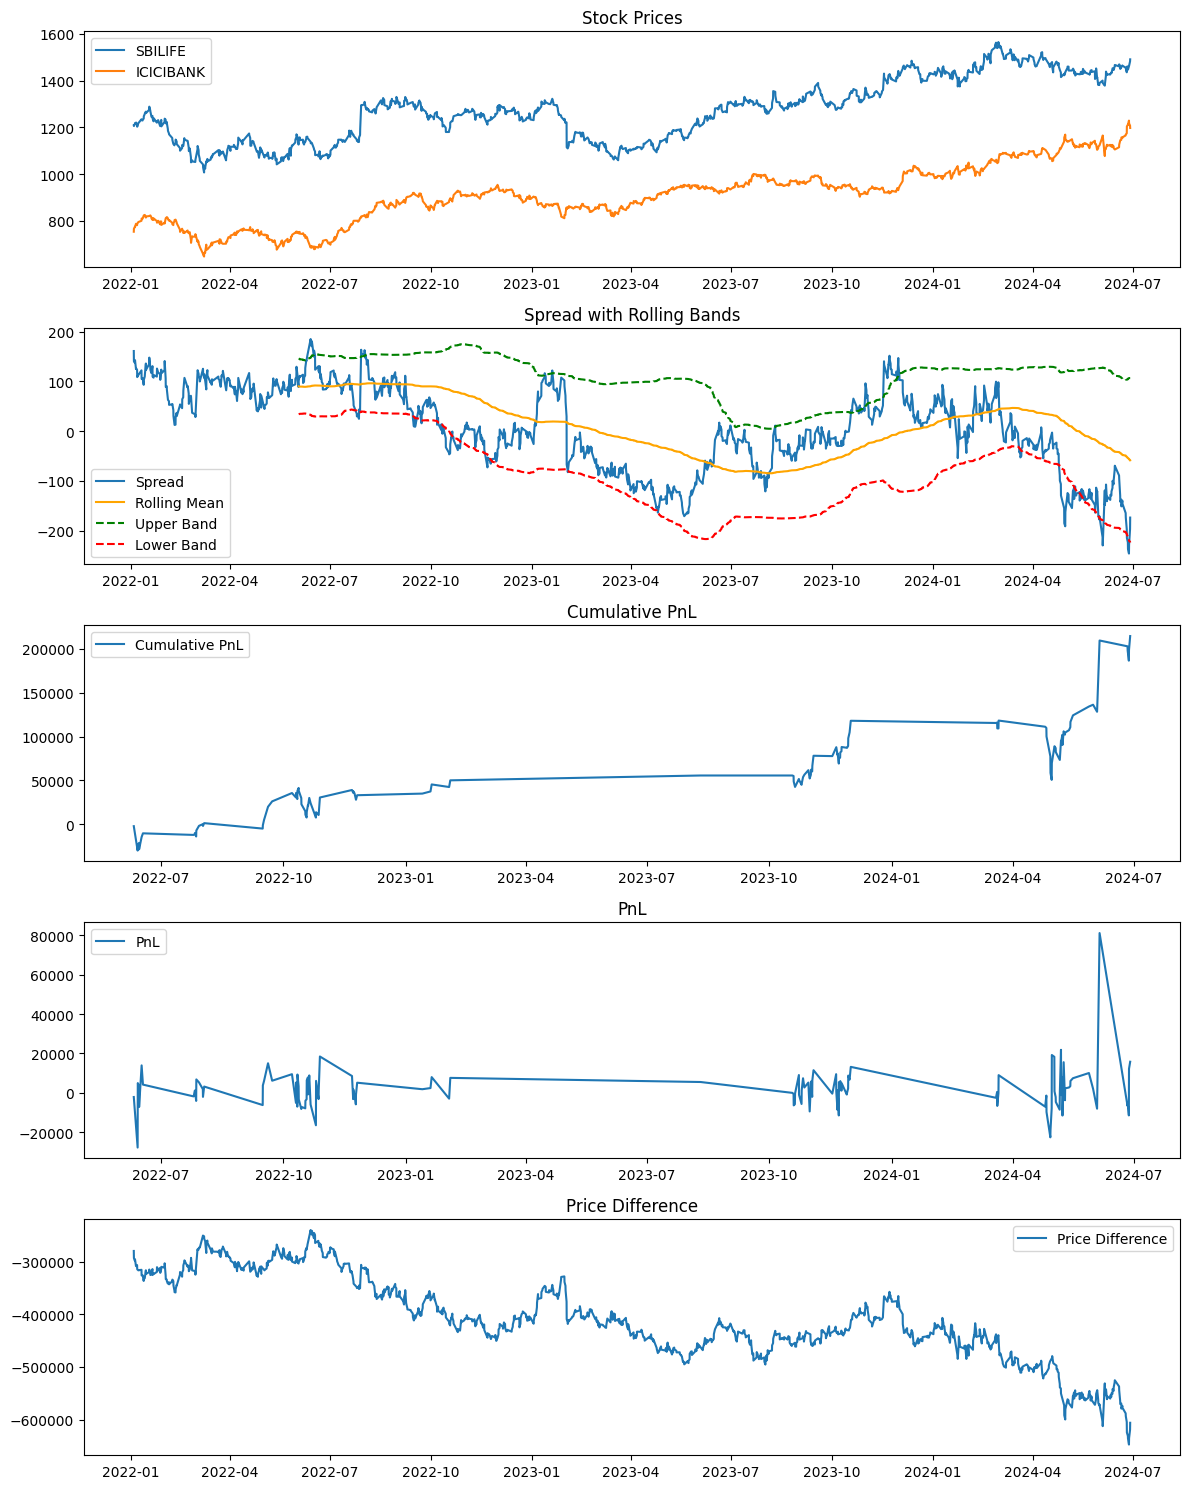

214453.0215272552
2.4607296870810655
-12.225865633529972
1.3903825127483573
0.019795432003685432
0.033340925141625656
0.5419847328244275


In [8]:
# Execute pair trader for the co-integrated pair of SBILIFE (lot size 375) and ICICIBANK (lot size 700)
symbol1 = 'SBILIFE'
symbol2 = 'ICICIBANK'
data1 = pairs_trader.data[symbol1]
data2 = pairs_trader.data[symbol2]
lots_s1 = 375
lots_s2 = 700
pair_trader = SinglePairTrader(symbol1, symbol2, data1, data2, lots_s1, lots_s2)

if pair_trader.test_cointegration():
    pair_trader.calculate_spread()
    if pair_trader.test_spread_stationarity():
        pair_trader.backtest()
        pair_trader.calculate_metrics()
        pair_trader.plot_results()
        print(pair_trader.total_return)
        print(pair_trader.sharpe_ratio)
        print(pair_trader.max_drawdown)
        print(pair_trader.beta)
        print(pair_trader.coint_pvalue)
        print(pair_trader.adf_pvalue)
        print(pair_trader.winrate)
    else:
        print("Spread is not stationary")


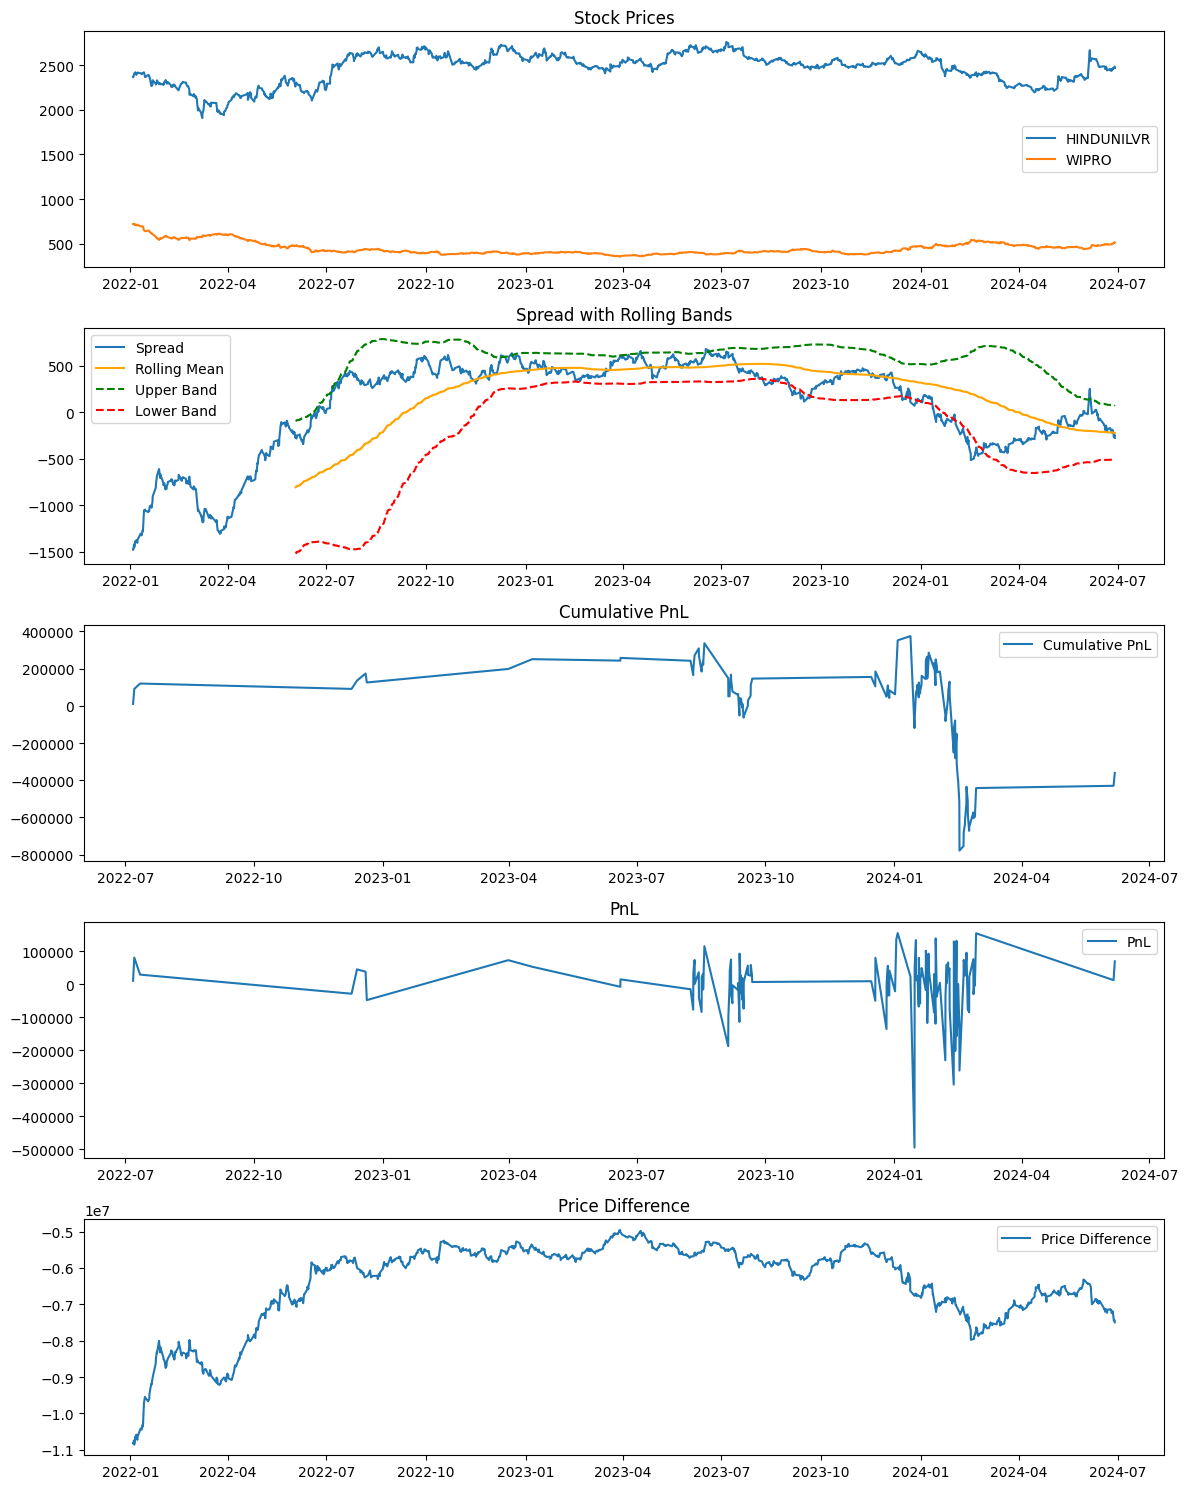

-360554.52247699536
-0.5125155063781903
-3.074899152015962
5.345265224372826
0.003909302701066269
0.0468395688925717
0.6115702479338843


In [10]:
# Execute pair trader for the co-integrated pair of HINDUNILVR (300 lots) and WIPRO (3000 lots)
symbol1 = 'HINDUNILVR'
symbol2 = 'WIPRO'
data1 = pairs_trader.data[symbol1]
data2 = pairs_trader.data[symbol2]
lots_s1 = 300
lots_s2 = 3000 
pair_trader = SinglePairTrader(symbol1, symbol2, data1, data2, lots_s1, lots_s2)

if pair_trader.test_cointegration():
    pair_trader.calculate_spread()
    if pair_trader.test_spread_stationarity():
        pair_trader.backtest()
        pair_trader.calculate_metrics()
        pair_trader.plot_results()
        print(pair_trader.total_return)
        print(pair_trader.sharpe_ratio)
        print(pair_trader.max_drawdown)
        print(pair_trader.beta)
        print(pair_trader.coint_pvalue)
        print(pair_trader.adf_pvalue)
        print(pair_trader.winrate)
    else:
        print("Spread is not stationary")



In [16]:
class HeatmapGenerator:
    def __init__(self, symbols, data):
        self.symbols = symbols
        self.data = data

    def generate_cointegration_heatmap(self, save_as_file=False):
        matrix_size = len(self.symbols)
        pvalues = np.zeros((matrix_size, matrix_size))

        for i, symbol1 in enumerate(self.symbols):
            for j, symbol2 in enumerate(self.symbols):
                if i != j:
                    _, pvalue, _ = coint(self.data[symbol1], self.data[symbol2])
                    pvalues[i, j] = pvalue

        plt.figure(figsize=(12, 10))
        sns.heatmap(pvalues, xticklabels=self.symbols, yticklabels=self.symbols, annot=True, cmap='coolwarm')
        plt.title('Cointegration P-Values Heatmap')
        plt.show()
        if save_as_file:
            with pd.ExcelWriter("cointegration_matrix.xlsx") as writer:
                pvalues_df = pd.DataFrame(pvalues, index=self.symbols, columns=self.symbols)
                pvalues_df.to_excel(writer, sheet_name='Cointegration P-Values')

    def generate_correlation_heatmap(self, save_as_file=False):
        correlation_matrix = self.data.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=self.symbols, yticklabels=self.symbols)
        plt.title('Correlation Coefficient Heatmap')
        plt.show()
        if save_as_file:
            with pd.ExcelWriter("correlation_matrix.xlsx") as writer:
                correlation_matrix.to_excel(writer, sheet_name='Correlation Coefficients')

    def save_heatmaps_to_excel(self, filename="heatmaps.xlsx"):
        with pd.ExcelWriter(filename) as writer:
            # Cointegration heatmap
            matrix_size = len(self.symbols)
            pvalues = np.zeros((matrix_size, matrix_size))

            for i, symbol1 in enumerate(self.symbols):
                for j, symbol2 in enumerate(self.symbols):
                    if i != j:
                        _, pvalue, _ = coint(self.data[symbol1], self.data[symbol2])
                        pvalues[i, j] = pvalue

            pvalues_df = pd.DataFrame(pvalues, index=self.symbols, columns=self.symbols)
            pvalues_df.to_excel(writer, sheet_name='Cointegration P-Values')

            # Correlation heatmap
            correlation_matrix = self.data.corr()
            correlation_matrix.to_excel(writer, sheet_name='Correlation Coefficients')

        print(f"Heatmaps saved to {filename}")

heatmap_data = pairs_trader.data

heatmap_generator = HeatmapGenerator(symbols, heatmap_data)

# heatmap_generator.generate_cointegration_heatmap(save_as_file=True)
# heatmap_generator.generate_correlation_heatmap(save_as_file=True)
heatmap_generator.save_heatmaps_to_excel("heatmaps.xlsx")

Heatmaps saved to heatmaps.xlsx
